#### Sampling on a subgrid

This works for very small networks. Typical real-world networks have far too many degrees of freedom.

However, we can select a subspace to grid and evaluate. This involves the grid sampling mode "naive_subgrid".

The subspace is defined by a set of vectors that span it.

In [2]:
import sys
sys.path.insert(1, '/home/heber/packages/TATi-unstable/lib/python3.5/site-packages')

In [6]:
from TATi.options.pythonoptions import PythonOptions
from TATi.model import Model as tati

options = PythonOptions()
options.set_options(
    batch_data_files=["dataset-twoclusters.csv"],
    fix_parameters="output/biases/Variable:0=-0.045677684",
    output_activation="linear",
    learning_rate=0.1,
    loss="mean_squared",
    max_steps=1,
    seed=426)

nn = tati(options)
nn.init_input_pipeline()
nn.init_network(None, setup=None)

In [8]:
from TATi.samplers.grid.samplingmodes import SamplingModes

more_options = {
    "exclude_parameters": [],
    "samples_weights": 10,
    "samples_biases": 1,
    "interval_weights": [-1,1],
    "interval_biases": [-1,1],
}
for k,v in more_options.items():
    if not k in options:
        options.add(k)
    options.set(k, v)

In [10]:
from TATi.samplers.grid.subgridsampler import SubgridSampler
import numpy as np

# create a subgrid sampler class
subgrid_sampler = SubgridSampler(
    network_model=nn, 
    exclude_parameters=[], 
    samples_weights=options.samples_weights,
    degrees=["x1", "x2"],
    directions=np.asarray([[1.,0.]])
)

subgrid_sampler.setup_start(
    trajectory_file=None,
    trajectory_stepnr=None,
    interval_weights=options.interval_weights,
    interval_offsets=[])

# we need to set max_steps to the number of grid points
options.max_steps=subgrid_sampler.get_max_steps()
nn.reset_parameters(options)

# and re-create the input pipeline such that enough batches are present
nn.init_input_pipeline()
nn.reset_dataset()

We sample using the same loop as before.

In [12]:
import numpy as np

def sample_grid(grid_sampler): 
    # set the sampler to the start of the grid
    grid_sampler.goto_start()

    # iterate over every grid point
    coords = []
    losses = []
    for i in range(options.max_steps):
        coords_eval = np.asarray(grid_sampler.set_step())
        loss_eval, acc_eval = grid_sampler.evaluate_loss()
        coords.append(coords_eval)
        losses.append(loss_eval)
        grid_sampler.goto_next_step()
    
    samples = np.zeros((len(coords),coords[0].shape[0]+1))
    samples[:,:-1] = np.asarray(coords)
    samples[:,-1:] = np.asarray(losses)
    return np.asarray(samples)

In [13]:
subgrid_samples = sample_grid(subgrid_sampler)

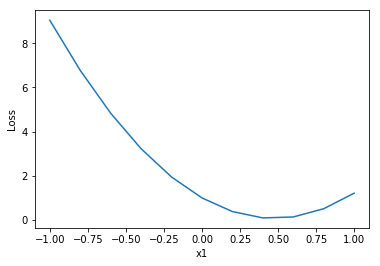

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.plot(subgrid_samples[:,0], subgrid_samples[:,1].astype(float))
plt.xlabel("x1")
plt.ylabel("Loss")
plt.show()